This notebook was mostly developed after I'd gone through the TensorFlow tutorials. It implements a convolutional neural network for the MNIST dataset. I also include some figures and notes that helped me understand the workings of the program.

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import random

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.18.0


In [24]:
# x is pixel grayscale values, y is labels
(xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
print("xTrain Shape: ", xTrain.shape)
print("yTrain Shape: ", yTrain.shape)
print("xTest Shape: ", xTest.shape)
print("yTest Shape: ", yTest.shape)
print(xTrain.shape[0], " training images with resolution: ", xTrain.shape[1],"x",xTrain.shape[2])
print(xTest.shape[0], " test images with resolution: ", xTest.shape[1],"x",xTest.shape[2])


xTrain Shape:  (60000, 28, 28)
yTrain Shape:  (60000,)
xTest Shape:  (10000, 28, 28)
yTest Shape:  (10000,)
60000  training images with resolution:  28 x 28
10000  test images with resolution:  28 x 28


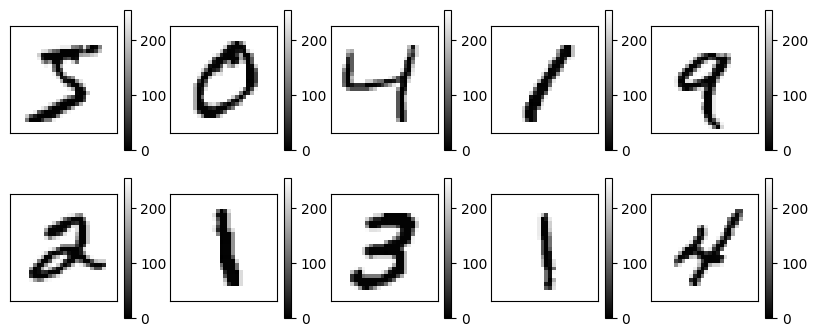

In [26]:
#Maybe these look better colors inverted
xTrain_inverted = 255 - xTrain
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(xTrain_inverted[i], cmap='gray')
    plt.colorbar()

Values must be normalized from 0-255 (8-bit) to a float in range (0,1):

In [5]:
(xTrain, xTest) = (xTrain.astype('float32')/255.0, xTest.astype('float32')/255.0)
print(type(xTrain[0,0,0]))
xTrain.shape

<class 'numpy.float32'>


(60000, 28, 28)

xTrain and xTest must be expanded because this is a CNN. Conv2D requires a 3 dimensional input because it can receive batches of n images. In this case, it receives individual images where n=1, mainly because these are grayscale.

In [6]:
xTrain = np.expand_dims(xTrain, -1)
print("Now that dims are expanded:")
print(xTrain.shape)

Now that dims are expanded:
(60000, 28, 28, 1)


In [7]:
model = tf.keras.Sequential(
    [
        layers.Input(shape=(28, 28, 1)), #Note: reason the input is 28,28,1 is because this image is 28x28 pixels grayscale. RGB would be 28,28,3
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(10, activation="softmax"),
    ]
)

In [8]:
# This converts the labels 0-9 to 1/0 encoded labels
# aka 5 converts to [0,0,0,0,0,1,0,0,0,0]
# This increases the rank of the matrix by one (expands dimension)
#   Size of the newest dimension = highest integer of previous
#
# However, the default yTrain and yTest can be used with sparse categorical. Categorical just seems to be used in many examples.
print("yTrain Before: ", yTrain[:10])
print(yTrain.shape)
yTrainCat = keras.utils.to_categorical(yTrain, 10)
yTestCat = keras.utils.to_categorical(yTest, 10)
print("Used keras.utils.to_categorical")
print("yTrainCat after: ", yTrainCat[:10])
print(yTrainCat.shape)

yTrain Before:  [5 0 4 1 9 2 1 3 1 4]
(60000,)
Used keras.utils.to_categorical
yTrainCat after:  [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
(60000, 10)


In [9]:
batch_size = 128
epochs = 4

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(xTrain, yTrainCat, epochs=epochs, validation_split=0.1)
# Default batch size is 32, which is why there are 1688 per epoch with no specification (54016/32)
# It would be 422 per epoch if batch size set to 128
# Batch size: How often the algorithm recaculates a gradient
  # The gradient calculated is the changes to each weight that minimizes error
# There are 1688*32 images trained per epoch, therefore 54016 total (actually since there's 54k there's 16 as a rounding error)

# Validation split: Split off a portion of the training dataset to be used for validation.
  # With validation_split=0.1 the 60k images are separated to 54k training and 6k validation


Epoch 1/4
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8725 - loss: 0.4225 - val_accuracy: 0.9832 - val_loss: 0.0565
Epoch 2/4
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9769 - loss: 0.0760 - val_accuracy: 0.9887 - val_loss: 0.0411
Epoch 3/4
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9840 - loss: 0.0547 - val_accuracy: 0.9895 - val_loss: 0.0397
Epoch 4/4
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9865 - loss: 0.0427 - val_accuracy: 0.9910 - val_loss: 0.0334


In [10]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

The below cell chooses 10 random images from the test dataset. Rerun this cell to pick 10 new random ones. The logit value format is displayed below. These values correspond to a perceived likelihood of the image being recognized as a certain number.

In [30]:
#Just to illustrate the logit output of this model
numImages = 10
startIndex = random.randint(0, xTest.shape[0]-numImages-1)
endIndex = startIndex + numImages
logitvals = probability_model(xTest[startIndex:endIndex])
print(f"Chosen Images #{startIndex}-{endIndex}\n")
logitvals

Chosen Images #4244-4254



<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0.08533675, 0.08533675, 0.08533675, 0.23196931, 0.08533675,
        0.08533675, 0.08533675, 0.08533675, 0.08533675, 0.08533675],
       [0.08533674, 0.08533674, 0.08533674, 0.08533674, 0.08533674,
        0.08533674, 0.08533674, 0.08533674, 0.08533674, 0.2319693 ],
       [0.08533674, 0.08533674, 0.08533674, 0.08533674, 0.08533674,
        0.08533674, 0.08533674, 0.08533674, 0.2319693 , 0.08533674],
       [0.08533675, 0.08533675, 0.23196931, 0.08533675, 0.08533675,
        0.08533675, 0.08533675, 0.08533675, 0.08533675, 0.08533675],
       [0.08533674, 0.08533674, 0.08533674, 0.08533674, 0.08533674,
        0.08533674, 0.08533674, 0.08533674, 0.2319693 , 0.08533674],
       [0.08533675, 0.23196931, 0.08533675, 0.08533675, 0.08533675,
        0.08533675, 0.08533675, 0.08533675, 0.08533675, 0.08533675],
       [0.08533675, 0.08533675, 0.23196931, 0.08533675, 0.08533675,
        0.08533675, 0.08533675, 0.08533675, 0.08533675, 0.08

Now I pick 10 random images from the test dataset and see if the Convolutional Neural Network model gets them right! It should get them right about 99% of the time, so it can be hard to find incorrect cases. And in my opinion, most of the cases it gets wrong would be hard even for me...

Chosen Images #4244-4254



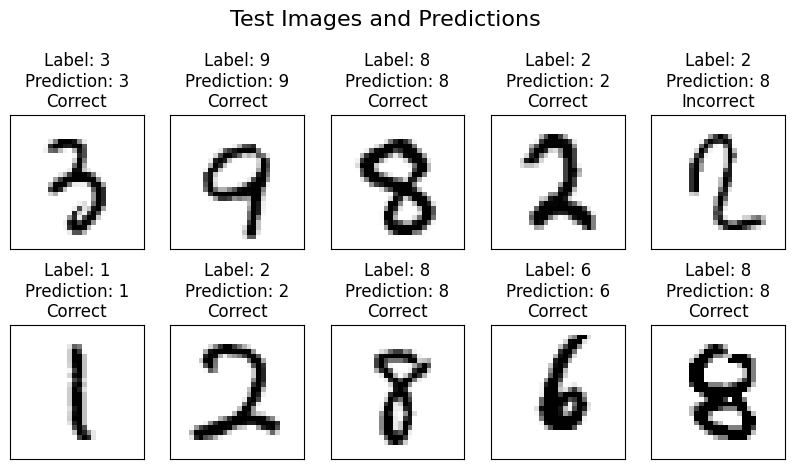

In [45]:
# Determining prediction based on the most likely estimate from logitvals
predictions=[None]*10
for i in range(0,10):
  predictions[i] = tf.argmax(logitvals[i])

# Displaying with pyplot
xTest_inverted = 255-xTest
print(f"Chosen Images #{startIndex}-{endIndex}\n")
plt.figure(figsize=(10,5))
plt.suptitle("Test Images and Predictions", fontsize=16, y=1.05)
for i in range(numImages):
  plt.subplot(2,5,i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(xTest_inverted[startIndex+i], cmap='gray')
  #plt.colorbar() #turned off for now
  true_label = yTest[startIndex + i]
  prediction = predictions[i].numpy()
  result = "Correct" if true_label == prediction else "Incorrect"
  plt.title(f"Label: {true_label}\nPrediction: {prediction}\n{result}")



In [46]:
# Some testing to get the above plot working correctly
nextline_val = (len(predictions)+1)//2
print("Neural Network Predictions:")
for i,val in enumerate(predictions):
  if i==nextline_val: print()
  print(val.numpy(), end=" ")
print()
#
matches = yTest[startIndex:startIndex + numImages] == np.array(predictions)

# Reshape the matches into a 2x5 matrix for easier viewing
match_matrix = matches.reshape(2, 5)

# Print the match matrix

print("Match Matrix (True = match, False = mismatch):")
print(match_matrix)

Neural Network Predictions:
3 9 8 2 8 
1 2 8 6 8 
Match Matrix (True = match, False = mismatch):
[[ True  True  True  True False]
 [ True  True  True  True  True]]
